## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

## Settings

In [2]:
# suppress scientific notation for floats
pd.set_option('display.float_format', lambda x: '%.3f' % x)
np.set_printoptions(suppress=True, formatter={'float_kind': lambda x: '%.3f' % x})

## Data Preparation

In [3]:
# we want to predict values for Hm
target = 'Hm'
# read csv file into pandas dataframe
dataset = pd.read_csv('https://raw.githubusercontent.com/timebertt/ml-cycling-data/master/jupyter/myrides_01_Dataset_2.csv',
                          na_values='?', comment='\t',
                          sep=';', skipinitialspace=True, decimal=',')

In [4]:
# have a first look at the data
display(dataset.head())
# display number of rows and columns
print("original shape: {}".format(dataset.shape))

,HR,Hm,km,maxHR,maxHm,max_speed,minHm,position_lat_max,position_lat_min,position_long_max,position_long_min,speed,bike,type,date,endtime,starttime,rider_weight,rider_height,ride_type,duration
0,nan,566.600,36.148,nan,528.600,53.878,289.600,48.779,48.709,9.572,9.470,19.632,Rose PRO,Rennrad,03.01.20,16:15:33,14:17:03,76,183,Pendeln,01:58:30
1,nan,707.600,22.785,nan,484.400,55.930,313.000,48.756,48.716,9.520,9.506,25.750,Rose PRO,Rennrad,06.10.18,14:00:01,12:50:55,73,183,Training,01:09:06
2,nan,191.600,35.779,nan,323.200,39.535,237.600,48.798,48.704,9.517,9.171,21.016,Stevens Elite,Trecking,27.08.19,19:52:13,18:10:02,73,183,Pendeln,01:42:11
3,nan,234.000,35.259,nan,347.600,39.132,246.800,48.798,48.704,9.517,9.170,22.139,Stevens Elite,Trecking,04.04.18,19:27:20,17:51:38,74,183,Pendeln,01:35:42
4,nan,447.800,22.034,nan,465.000,57.676,281.800,48.766,48.717,9.520,9.491,26.450,Rose PRO,Rennrad,20.09.17,16:47:32,15:51:00,73,183,Training,00:56:32


original shape: (564, 21)


### Drop columns with missing values

In [5]:
# identify number of missing values for each column
isna = dataset.isna().sum()
isna

HR                   522
Hm                     0
km                     0
maxHR                522
maxHm                  0
max_speed              0
minHm                  0
position_lat_max       0
position_lat_min       0
position_long_max      0
position_long_min      0
speed                  0
bike                   0
type                   0
date                   0
endtime                0
starttime              0
rider_weight           0
rider_height           0
ride_type              0
duration               0
dtype: int64

In [6]:
# drop columns that have more than 10% missing values
for column, count in isna.items():
  if count < len(dataset) * 0.1:
    continue

  print("dropping {}, as {:.2f}% of rows have a missing value".format(column, count / len(dataset) * 100))
  dataset.pop(column)

print("new shape: {}".format(dataset.shape))

dropping HR, as 92.55% of rows have a missing value
dropping maxHR, as 92.55% of rows have a missing value
new shape: (564, 19)


### Convert date and time values

In [7]:
# convert date from string to seconds since the epoch
dataset['date'] = (pd.to_datetime(dataset['date']) - pd.Timestamp("1970-01-01")).dt.total_seconds()
# convert duration from string to seconds
dataset['duration'] = pd.to_timedelta(dataset['duration']).dt.total_seconds()
# convert starttime from string to seconds (from midnight)
dataset['starttime'] = pd.to_timedelta(dataset['starttime']).dt.total_seconds()
# convert endtime from string to seconds (from midnight)
dataset['endtime'] = pd.to_timedelta(dataset['endtime']).dt.total_seconds()

# inspect the converted columns
with pd.option_context('display.float_format', lambda x: "%.0f" % x):
  display(dataset[["date","duration","starttime","endtime"]].head())

,date,duration,starttime,endtime
0,1583020800,7110,51423,58533
1,1528588800,4146,46255,50401
2,1566864000,6131,65402,71533
3,1522800000,5742,64298,70040
4,1505865600,3392,57060,60452


### Convert categorical variables into indicator variables

In [8]:
# convert categorical variables to numerical values to have a uniform input for the model
dataset = pd.get_dummies(dataset, columns=['bike'], prefix='bike', prefix_sep='.')
dataset = pd.get_dummies(dataset, columns=['type'], prefix='type', prefix_sep='.')
dataset = pd.get_dummies(dataset, columns=['ride_type'], prefix='ride_type', prefix_sep='.')

# inspect the resulting indicator columns
display(dataset[[col for col in dataset if '.' in col]].head())

print("new shape: {}".format(dataset.shape))

,bike.CUBE AIM RACE,bike.Carver Distaco 6000,bike.Giant,bike.Mietrad - GHOST,bike.Rose PRO,bike.Stevens 98,bike.Stevens Elite,type.MTB,type.Rennrad,type.Trecking,ride_type.Pendeln,ride_type.Race,ride_type.Training
0,0,0,0,0,1,0,0,0,1,0,1,0,0
1,0,0,0,0,1,0,0,0,1,0,0,0,1
2,0,0,0,0,0,0,1,0,0,1,1,0,0
3,0,0,0,0,0,0,1,0,0,1,1,0,0
4,0,0,0,0,1,0,0,0,1,0,0,0,1


new shape: (564, 29)


### Split the data into train and test

In [9]:
# split the dataset into a training set and a test set (use 80% as training data, set random_state for reproducibility)
train_dataset = dataset.sample(frac=0.8, random_state=1)
test_dataset = dataset.drop(train_dataset.index)

### Remove outliers from dataset

In [10]:
# display statistics: comparing min/max value with 5th/95th percentile reveals outliers in some columns, probably erroneous values (e.g. 5508.800 Hm)
train_dataset_stats = train_dataset.describe(percentiles=[.05, .95])
train_dataset_stats[['Hm','duration','minHm','km']].transpose()

,count,mean,std,min,5%,50%,95%,max
Hm,451.000,509.738,622.016,28.400,150.000,283.400,1637.900,5508.800
duration,451.000,7314.887,6343.087,616.000,2700.000,5586.000,18007.000,46624.000
minHm,451.000,265.398,148.545,-60.600,160.000,253.400,346.100,1533.800
km,451.000,42.577,31.792,2.836,11.817,35.081,102.090,268.309


In [11]:
print("shape: {}".format(train_dataset.shape))

for col in train_dataset.columns:
 # if standard deviation is 0, we can't calculate z-score (division by zero)
  if train_dataset_stats[col]['std'] <= 0:
    continue

  # ignore indicator variables (outlier detection not useful there)
  if '.' in col:
    continue

  # remove all rows having values outside (m-4std,m+4std) of col
  train_dataset = train_dataset[(np.abs(stats.zscore(train_dataset[col])) < 4)]
  
  print("new shape after dropping outliers for {}: {}".format(col, train_dataset.shape))

shape: (451, 29)
new shape after dropping outliers for Hm: (446, 29)
new shape after dropping outliers for km: (443, 29)
new shape after dropping outliers for maxHm: (435, 29)
new shape after dropping outliers for max_speed: (435, 29)
new shape after dropping outliers for minHm: (429, 29)
new shape after dropping outliers for position_lat_max: (417, 29)
new shape after dropping outliers for position_lat_min: (413, 29)
new shape after dropping outliers for position_long_max: (404, 29)
new shape after dropping outliers for position_long_min: (404, 29)
new shape after dropping outliers for speed: (404, 29)
new shape after dropping outliers for date: (404, 29)
new shape after dropping outliers for endtime: (404, 29)
new shape after dropping outliers for starttime: (404, 29)
new shape after dropping outliers for rider_weight: (404, 29)
new shape after dropping outliers for duration: (398, 29)


In [12]:
# new stats after dropping outliers: min/max values are much closer to 5th/95th percentile
train_dataset_stats = train_dataset.describe(percentiles=[.05, .95])
train_dataset_stats[['Hm','duration','minHm','km']].transpose()

,count,mean,std,min,5%,50%,95%,max
Hm,398.000,390.419,305.852,30.600,150.370,255.800,1008.540,1918.800
duration,398.000,5864.528,2719.351,616.000,2721.700,5483.000,11221.350,20461.000
minHm,398.000,251.285,35.884,-15.600,201.960,253.200,302.960,374.000
km,398.000,36.435,17.801,3.814,11.987,35.011,72.490,130.602


### Split features from labels

In [13]:
# Separate the target value as the label from the features 
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop(target)
test_labels = test_features.pop(target)

## Feature Selection

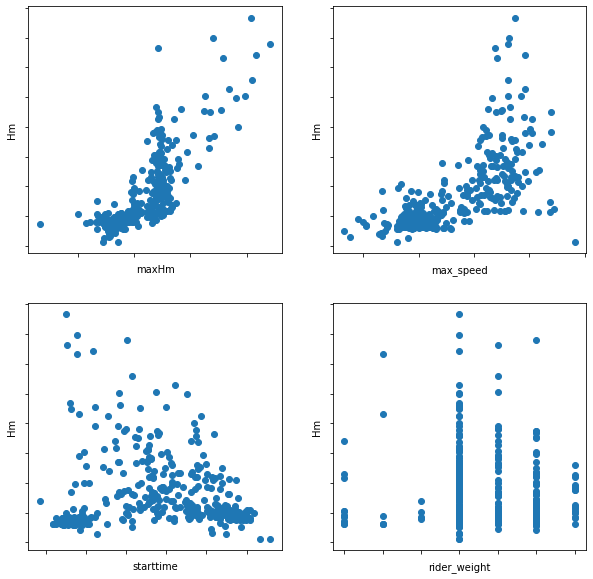

In [14]:
def visualize_correlation(df):
  plt.figure(figsize=(10, 10))
  i = 0
  for col, series in df.items():
    if col == target:
      continue

    i = i+1
    ax = plt.subplot(2, 2, i)
    plt.scatter(series, df[target])
    plt.xlabel(col)
    plt.ylabel(target)
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])

# scatter plots reveal different degrees of correlations between Hm as target value and possible features 
# e.g.: maxHm and max_speed show a correlation with Hm, while starttime and rider_weight seem to have no correlation with Hm at all
visualize_correlation(train_dataset[[target,'maxHm','max_speed','starttime','rider_weight']])

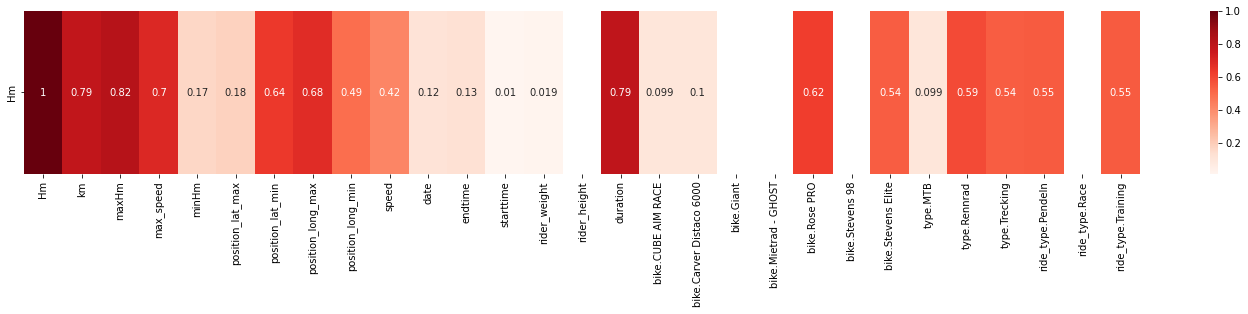

In [15]:
# use Pearson correlation coefficience to detect features with high relevance for label
plt.figure(figsize=(25,3))
cor = train_dataset.corr(method="pearson")
# use absolute value of the calculated correlation coefficients
sns.heatmap(abs(cor.iloc[:1]), annot=True, cmap=plt.cm.Reds)
plt.show()

In [16]:
# correlation with output variable
cor_target = abs(cor[target])
# select features with correlation coefficience of at least 0.1
relevant_features = cor_target[cor_target>0.1].drop(target)

print("number of selected features: {}".format(len(relevant_features)))
print()
print(relevant_features.sort_values(ascending=False))

# keep selected feature columns in train set and test set
train_features = train_features[relevant_features.index]
test_features = test_features[relevant_features.index]

number of selected features: 18

maxHm                0.820
duration             0.788
km                   0.786
max_speed            0.696
position_long_max    0.680
position_lat_min     0.640
bike.Rose PRO        0.623
type.Rennrad         0.588
ride_type.Pendeln    0.546
ride_type.Training   0.546
bike.Stevens Elite   0.540
type.Trecking        0.540
position_long_min    0.493
speed                0.423
position_lat_max     0.184
minHm                0.165
endtime              0.130
date                 0.118
Name: Hm, dtype: float64


## Normalization

In [17]:
# define normalization layer, will be used as first layer
normalizer = preprocessing.Normalization(name="normalization")
# calculate mean and variance based on training data and store it in normalization layer
normalizer.adapt(np.array(train_features))

In [18]:
# take a look at calculated mean and variance values
print("Mean: {}".format(normalizer.mean.numpy()))
print("Variance: {}".format(normalizer.variance.numpy()))

Mean: [[36.435 415.943 45.038 251.285 48.780 48.697 9.550 9.324 23.446
  1544765824.000 51768.082 5864.528 0.452 0.450 0.480 0.450 0.467 0.533]]
Variance: [[316.084 11738.271 64.520 1284.403 0.001 0.001 0.004 0.023 10.568
  1304776302133248.000 234089872.000 7376291.000 0.248 0.247 0.250 0.247
  0.249 0.249]]


In [19]:
# demonstrate normalization on first row
first = np.array(train_features[:1])

print('First row:', first[0])
print()
# basically calculates the z-score for each feature
print('Normalized:', normalizer(first).numpy()[0])

First row: [65.108 517.600 56.902 287.200 48.793 48.708 9.743 9.515 27.227
 1588809600.000 43228.000 9144.000 1.000 0.000 1.000 0.000 0.000 1.000]

Normalized: [1.613 0.938 1.477 1.002 0.467 0.310 3.109 1.250 1.163 1.219 -0.558 1.207
 1.101 -0.904 1.041 -0.904 -0.937 0.937]


## Multi-Layer-Perceptron (Deep Neural Network)

In [20]:
# dict for storing models as well as training loss/metrics history for each trained model
models = {}
training_histories = {}

In [21]:
# prepare reusable func for defining and training network
# for comparison of different configurations later on
def compile_and_train_model(name="", hidden_layers=None, loss=None):
  # define a simple sequential model and add all our layers
  model = keras.Sequential(name=name)
  model.add(normalizer)
  for l in hidden_layers:
    model.add(l)
  model.add(layers.Dense(1, name="output"))

  # decrease learning rate as training progresses for a more stable result and less overfitting
  lr_schedule = keras.optimizers.schedules.ExponentialDecay(
                    initial_learning_rate=5e-4, decay_steps=100000, decay_rate=0.96, staircase=True
                )

  # put everything together
  model.compile(
                loss=loss,
                optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                # metrics to record during training and evaluate with test data
                metrics=[tf.losses.MeanAbsoluteError(),
                        tf.losses.MeanAbsolutePercentageError(),
                        tf.losses.MeanSquaredError(),
                        tf.losses.MeanSquaredLogarithmicError()]
                )

  # train model and save loss/metrics history
  print('training model {}'.format(name))
  history = model.fit(
    train_features, train_labels,
    epochs=500,
    verbose=0,
    # 20% of training data is used for evaluating loss exclusively but not for training,
    # i.e. to detect overfitting
    validation_split=0.2)
  
  # save model and metrics for comparison
  models[model.name] = model
  training_histories[model.name] = history

In [22]:
# prepare function for plotting multiple loss histories next to each other
def plot_loss_histories(hist):
  plt.figure(figsize=(25, 5))

  i = 0
  for model_name, history in hist.items():
    i = i+1
    ax = plt.subplot(1, len(hist), i)
    ax.set(title=f'{model_name} ({history.model.loss.name})')
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    # heuristically determine some fitting y axis range
    plt.ylim([history.history['loss'][-1]*0.7, history.history['val_loss'][int(history.epoch[-1]*0.1)]])
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)

# prepare function for comparing the training results (metrics) in a table
def compare_model_metrics(hist):
  training_metrics = {}

  for model_name, history in hist.items():
    training_metrics[model_name] = pd.DataFrame(history.history).iloc[-1]

  return pd.DataFrame(training_metrics)

### Compare different hidden layer sizes/widths

In [23]:
# first model with a single but wide layer
compile_and_train_model(
    name="one_hidden_layer",
    hidden_layers=[
      layers.Dense(64, activation="relu", name="layer1"),
    ],
    loss=tf.losses.MeanAbsoluteError()
)

training model one_hidden_layer


In [24]:
# get some short summary of the trained model
models['one_hidden_layer'].summary()

Model: "one_hidden_layer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 18)                37        
_________________________________________________________________
layer1 (Dense)               (None, 64)                1216      
_________________________________________________________________
output (Dense)               (None, 1)                 65        
Total params: 1,318
Trainable params: 1,281
Non-trainable params: 37
_________________________________________________________________


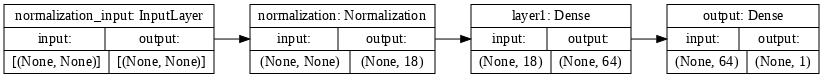

In [25]:
# visualize the trained model
tf.keras.utils.plot_model(model=models['one_hidden_layer'] , rankdir="LR", dpi=72, show_shapes=True)

In [26]:
# train a few other models

# model with two layers
compile_and_train_model(
    name="two_hidden_layers",
    hidden_layers=[
      layers.Dense(32, activation="relu", name="layer1"),
      layers.Dense(16, activation='relu', name="layer2"),
    ],
    loss=tf.losses.MeanAbsoluteError()
)

# model with two wide layers
compile_and_train_model(
    name="two_wide_hidden_layers",
    hidden_layers=[
      layers.Dense(64, activation="relu", name="layer1"),
      layers.Dense(64, activation='relu', name="layer2"),
    ],
    loss=tf.losses.MeanAbsoluteError()
)

# model with three wide layers
compile_and_train_model(
    name="three_hidden_layers",
    hidden_layers=[
      layers.Dense(128, activation="relu", name="layer1"),
      layers.Dense(64, activation='relu', name="layer2"),
      layers.Dense(32, activation='relu', name="layer3"),
    ],
    loss=tf.losses.MeanAbsoluteError()
)

training model two_hidden_layers
training model two_wide_hidden_layers
training model three_hidden_layers


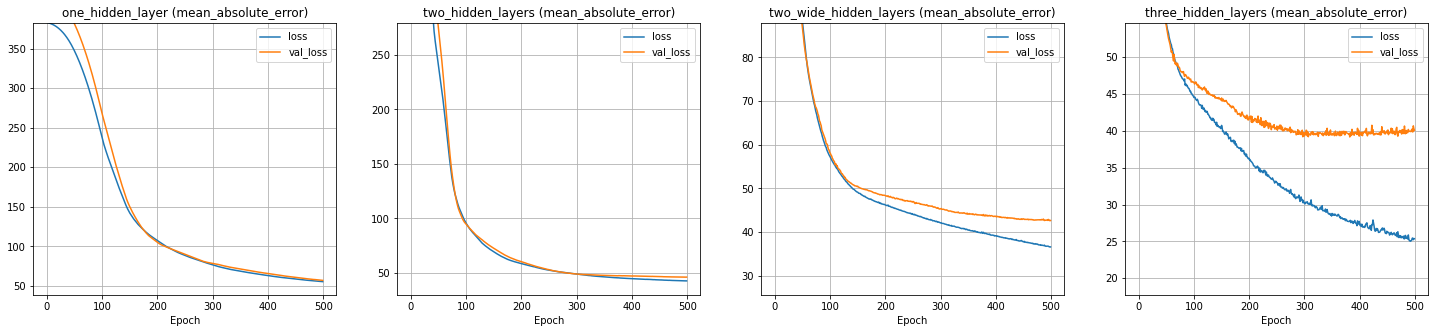

In [27]:
# get all histories from this experiment
layers_comparison = {
    model_name: training_histories[model_name]
    for model_name in ['one_hidden_layer','two_hidden_layers','two_wide_hidden_layers','three_hidden_layers']
    }

plot_loss_histories(layers_comparison)

In [28]:
compare_model_metrics(layers_comparison)

,one_hidden_layer,two_hidden_layers,two_wide_hidden_layers,three_hidden_layers
loss,55.435,42.578,36.566,25.368
mean_absolute_error,55.443,42.520,36.628,25.303
mean_absolute_percentage_error,18.058,12.454,9.847,6.666
mean_squared_error,8517.735,5009.656,3550.198,2098.183
mean_squared_logarithmic_error,0.100,0.037,0.019,0.010
val_loss,57.035,46.057,42.623,40.083
val_mean_absolute_error,59.124,48.015,44.176,43.406
val_mean_absolute_percentage_error,15.554,12.841,11.610,10.722
val_mean_squared_error,9331.609,6308.297,5308.362,4706.478
val_mean_squared_logarithmic_error,0.106,0.075,0.052,0.031


### Compare different loss functions

In [29]:
# train a few models with different loss functions

compile_and_train_model(
    name="mean_absolute_error",
    hidden_layers=[
      layers.Dense(32, activation="relu", name="layer1"),
      layers.Dense(16, activation='relu', name="layer2"),
    ],
    loss=tf.losses.MeanAbsoluteError()
)

compile_and_train_model(
    name="mean_absolute_percentage_error",
    hidden_layers=[
      layers.Dense(32, activation="relu", name="layer1"),
      layers.Dense(16, activation='relu', name="layer2"),
    ],
    loss=tf.losses.MeanAbsolutePercentageError()
)

compile_and_train_model(
    name="mean_squared_error",
    hidden_layers=[
      layers.Dense(32, activation="relu", name="layer1"),
      layers.Dense(16, activation='relu', name="layer2"),
    ],
    loss=tf.losses.MeanSquaredError()
)

compile_and_train_model(
    name="mean_squared_logarithmic_error",
    hidden_layers=[
      layers.Dense(32, activation="relu", name="layer1"),
      layers.Dense(16, activation='relu', name="layer2"),
    ],
    loss=tf.losses.MeanSquaredLogarithmicError()
)

training model mean_absolute_error
training model mean_absolute_percentage_error
training model mean_squared_error
training model mean_squared_logarithmic_error


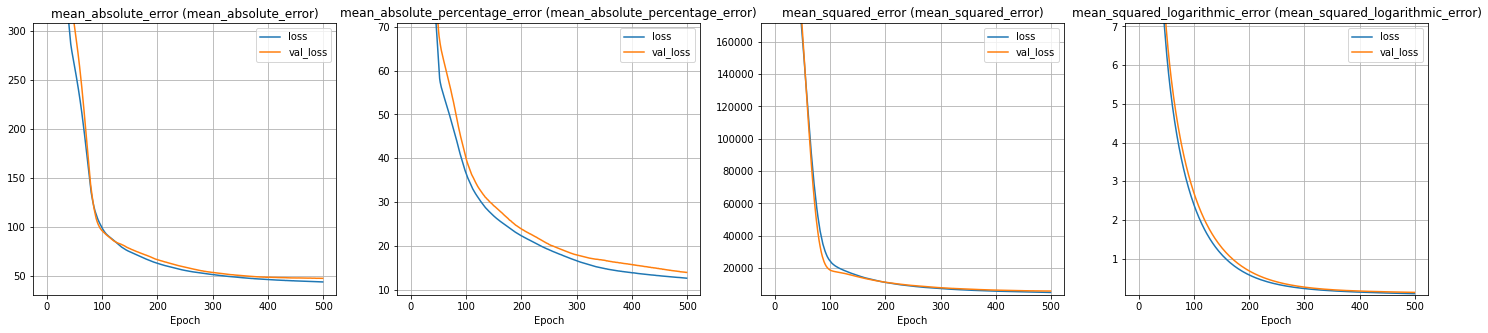

In [30]:
# get all histories from this experiment
loss_comparison = {
    model_name: training_histories[model_name]
    for model_name in ['mean_absolute_error','mean_absolute_percentage_error','mean_squared_error','mean_squared_logarithmic_error']
    }

plot_loss_histories(loss_comparison)

In [31]:
compare_model_metrics(loss_comparison)

,mean_absolute_error,mean_absolute_percentage_error,mean_squared_error,mean_squared_logarithmic_error
loss,43.736,12.634,4838.106,0.094
mean_absolute_error,43.833,54.171,46.110,90.706
mean_absolute_percentage_error,13.500,12.633,15.022,24.227
mean_squared_error,5157.344,9243.053,4826.667,21702.051
mean_squared_logarithmic_error,0.039,0.038,0.042,0.094
val_loss,47.392,13.957,5712.267,0.128
val_mean_absolute_error,49.089,59.537,50.050,92.849
val_mean_absolute_percentage_error,13.069,14.151,14.390,22.559
val_mean_squared_error,6523.564,9223.316,6653.535,18629.227
val_mean_squared_logarithmic_error,0.078,0.086,0.075,0.139


## Model Performance

As we have seen in the previous experiments, a network with two decently sized hidden layers using the mean absolute error as its loss function provided the best and most stable learning results.
Use this model (`two_hidden_layers`) for evaluating performance on the test data.

In [32]:
model = models['two_hidden_layers']

In [33]:
# predict target (Hm) for all test data with the trained model
test_predictions = model.predict(test_features).flatten()

In [34]:
# get metrics (MAE, MSE, etc.) for predictions on test data
test_metrics = model.evaluate(test_features, test_labels, verbose=0)
pd.DataFrame(test_metrics, index=model.metrics_names, columns=[model.name])

,two_hidden_layers
loss,376.663
mean_absolute_error,339.049
mean_absolute_percentage_error,78.832
mean_squared_error,2254624.500
mean_squared_logarithmic_error,0.357


### Analyze raw test predictions

In [35]:
# store raw prediction results for plotting
raw_predictions = {"raw test predictions": {"predictions": test_predictions, "labels": test_labels}}

# prepare some helper functions for displaying and plotting statistics of test results

def table_stats_absolute_error(predictions, labels):
  return pd.DataFrame(abs(predictions - labels)).describe(percentiles=[0.5,0.9,0.95]).transpose()

def table_stats_relative_error(predictions, labels):
  return pd.DataFrame(abs(predictions - labels) / labels).describe(percentiles=[0.5,0.9,0.95]).transpose()

def plot_scatter_relative_error(prediction_pairs):
  plt.figure(figsize=(10, 5))
  i = 0
  for key, pair in prediction_pairs.items():
    i = i+1
    predictions = pair["predictions"]
    labels = pair["labels"]
    error = abs((predictions - labels) / labels)
    plt.subplot(1, len(prediction_pairs), i)
    plt.scatter(labels, error)
    plt.title(key)
    plt.xlabel('Test Values [Hm]')
    plt.ylabel('Relative Prediction Error')

def plot_hist_absolute_error(prediction_pairs):
  plt.figure(figsize=(10, 5))
  i = 0
  for key, pair in prediction_pairs.items():
    i = i+1
    predictions = pair["predictions"]
    labels = pair["labels"]
    error = abs(predictions - labels)
    plt.subplot(1, len(prediction_pairs), i)
    plt.hist(error, bins=25)
    plt.title(key)
    plt.xlabel('Absolute Prediction Error [Hm]')
    plt.ylabel('Count')

def plot_hist_relative_error(prediction_pairs):
  plt.figure(figsize=(10, 5))
  i = 0
  for key, pair in prediction_pairs.items():
    i = i+1
    predictions = pair["predictions"]
    labels = pair["labels"]
    error = abs(predictions - labels) / labels
    plt.subplot(1, len(prediction_pairs), i)
    plt.hist(error, bins=25)
    plt.title(key)
    plt.xlabel('Relative Prediction Error [Hm]')
    plt.ylabel('Count')

In [36]:
table_stats_absolute_error(test_predictions, test_labels)

,count,mean,std,min,50%,90%,95%,max
Hm,113.000,376.663,1559.547,0.242,30.795,313.915,1149.059,10596.280


In [37]:
table_stats_relative_error(test_predictions, test_labels)

,count,mean,std,min,50%,90%,95%,max
Hm,113.000,0.856,3.442,0.001,0.108,0.362,2.755,23.542


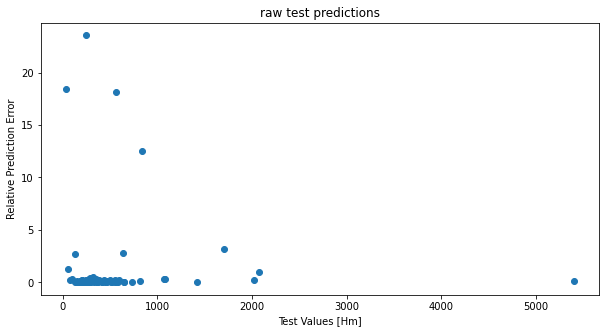

In [38]:
plot_scatter_relative_error(raw_predictions)

### Filtered test results

The above statistics and scatter plot reveal that there are only a few predictions with particularly high errors. However, the majority of predicitions has a comparatively low error. These outliers distort the statistics, as the arithmetic mean is sensitive to outliers.

Hence, drop 10% of predictions with the highest relative errors and only analyze the statistics of the other 90%.

In [39]:
p90 = np.quantile(abs(test_predictions - test_labels) / test_labels, 0.9)

# identify 10% predictions with highest errors
outlier_indices = []
for i, row in enumerate(test_predictions):
  error = abs(row - test_labels.iloc[i]) / test_labels.iloc[i]
  if error > p90:
    print("dropping test result with absolute error of {}".format(error))
    outlier_indices.append(i)

# drop outliers in predictions (and labels)
test_predictions_filtered = np.copy(test_predictions)
test_labels_filtered = np.copy(test_labels)
test_predictions_filtered = np.delete(test_predictions_filtered, outlier_indices, 0)
test_labels_filtered = np.delete(test_labels_filtered, outlier_indices, 0)

# store all prediction results together in one dict for 
all_predictions = {"raw test predictions": {"predictions": test_predictions, "labels": test_labels},
                   "top 90% predictions": {"predictions": test_predictions_filtered, "labels": test_labels_filtered}}

dropping test result with absolute error of 0.3669427075541452
dropping test result with absolute error of 0.4528102438563863
dropping test result with absolute error of 1.0066105262444585
dropping test result with absolute error of 12.560786963978781
dropping test result with absolute error of 18.384899336038178
dropping test result with absolute error of 2.818394492163071
dropping test result with absolute error of 1.2888765970865885
dropping test result with absolute error of 23.54243550585622
dropping test result with absolute error of 18.133978175708812
dropping test result with absolute error of 0.4737059744785962
dropping test result with absolute error of 3.1884532864418222
dropping test result with absolute error of 2.713060432558046


Display the filtered test result statistics:


In [40]:
table_stats_absolute_error(test_predictions_filtered, test_labels_filtered)

,count,mean,std,min,50%,90%,95%,max
0,101.000,47.590,75.435,0.242,27.239,88.000,118.391,540.317


In [41]:
table_stats_relative_error(test_predictions_filtered, test_labels_filtered)

,count,mean,std,min,50%,90%,95%,max
0,101.000,0.117,0.087,0.001,0.102,0.245,0.285,0.340


Compare raw test results with filtered test results in plots:

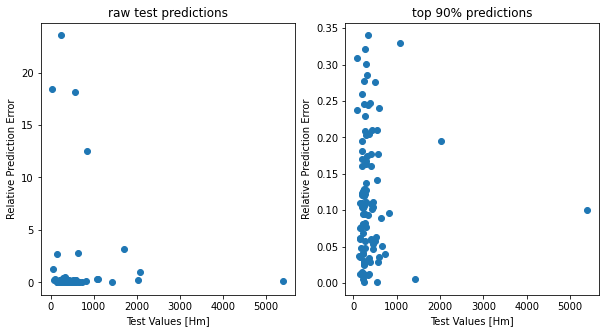

In [42]:
plot_scatter_relative_error(all_predictions)

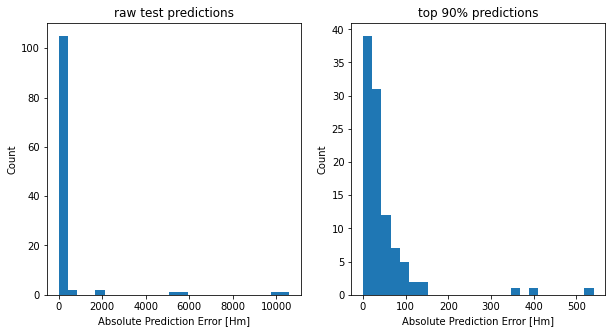

In [43]:
plot_hist_absolute_error(all_predictions)

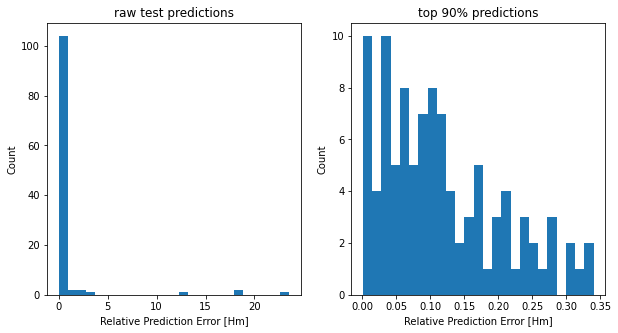

In [44]:
plot_hist_relative_error(all_predictions)